In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
# фиксируем RANDOM_SEED для воспроизводимости экспериментов
RANDOM_SEED = 42

### Загрузка данных

**Описание датасета**

Суть проекта — обнаружить нечестные рестораны, которые накручивают себе рейтинг, построив модель, которая предсказывает рейтинг ресторана.

* **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
* **City** — город, в котором находится ресторан;
* **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
* **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* **Price Range** — диапазон цен в ресторане;
* **Number of Reviews** — количество отзывов о ресторане;
* **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
* **URL_TA** — URL страницы ресторана на TripAdvisor;
* **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.


In [4]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

df_train = pd.read_csv('main_task.xls')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
# Дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем в один датасет

In [10]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Обработка пропусков

Начнем заполнение пропусков с колонки 'Cuisine Style'. 
Почиcтим столбец 'Cuisine Style', заполним пустые строки, разделим по разделителю ',',создадим DataFrame с количеством кухонь в ресторане.

In [12]:
df['Cuisine Style'] = df['Cuisine Style'].str.replace('[', '')

In [13]:
df['Cuisine Style'] = df['Cuisine Style'].str.replace(']', '')

In [14]:
df['Cuisine Style'] = df['Cuisine Style'].str.replace("'", '')

In [15]:
df['Cuisine Style'] = df['Cuisine Style'].str.strip()

In [19]:
df['Cuisine Style'].fillna('error', inplace=True)

In [21]:
data_c = pd.DataFrame()
for i in df.index:
    data_c = data_c.append(pd.DataFrame(
        [[len(df.iloc[i]['Cuisine Style'].split(','))]], columns=['Cuisine']), ignore_index=True)

In [22]:
data_c

,Cuisine
0,2
1,5
2,1
3,5
4,6
...,...
49995,4
49996,5
49997,2
49998,5


In [23]:
df = df.merge(data_c, how='left', left_on=df.index, right_on=data_c.index)

In [24]:
df.drop('key_0', axis=1, inplace=True)

In [25]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine
0,id_0,Paris,"Bar, Pub",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5
2,id_2,Edinburgh,Vegetarian Friendly,810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"Italian, Vegetarian Friendly, Vegan Options, G...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,4
49996,id_6340,Paris,"French, American, Bar, European, Vegetarian Fr...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,5
49997,id_1649,Stockholm,"Japanese, Sushi",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,2
49998,id_640,Warsaw,"Polish, European, Eastern European, Central Eu...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,5


In [26]:
df.drop(['Cuisine Style'], axis=1, inplace=True)

Обработаем колонку 'Price Range'.

In [27]:
df['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

Среди значений колонки есть пустые ячейки. Здесь у меня была задумка спарсить эти данные. Если вытаскивать значения по одному, то всё прекрасно работало (иногда вместо диапазона цены спарсилась кухня, так как диапазона цены не было на самом сайте), при 13000 пустых значений такой вариант не подходит. 


Я пыталась собирать данные в датафрейм res = pd.DataFrame(), первый столбец, которого это индекс ресторана из датафрейма, второй столбец - диапазон цены (или кухня, если диапазон не указан, или пустое значение, если нет ни того, ни другого). 
Данных я никаких не получила, процесс длился очень долго. Решила просто собрать данные в список, перешла в PyCharm, в режиме Debug получила данные с первых 10 ресторанов. Запустилась уже не в Debug, PyCharm вывел на экран 7 раз 'error' спустя несколько часов, на этом я решила закончить.
Если у вас есть возможность, то прокомментируйте, пожалуйста, моё решение, где исправить, в какую сторону смотреть. Спасибо.

In [ ]:
import requests
import csv
from bs4 import BeautifulSoup as bs

In [ ]:
url_rest = df['URL_TA'][df['Price Range'].isna()]

In [ ]:
url_rest

In [ ]:
headers = {'accept': '*/*',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Safari/537.36'}
base_url = 'https://www.tripadvisor.ru'

In [ ]:
def price_pare(url, headers):
    urls = []
    res = []
    #res = pd.DataFrame()
    for i in url_rest.index:
        url = base_url + url_rest[i]
        urls.append(url)
    session = requests.Session()
    for url in urls:
        request = session.get(url, headers=headers)
        if request.status_code == 200:
            request = session.get(url, headers=headers)
            page = bs(request.text, 'lxml')
            try:
                all_blocks = page.find_all('div', class_='_1ud-0ITN')
                # Выбираем первый по счету блок
                first_block = all_blocks[0]
                # Берём оттуда
                link = first_block.find('a', class_='_2mn01bsa')
                res.append(link.text)
                #res = res.append(pd.DataFrame([[url_rest.index, link.text]], columns = ['id', 'Price Range']), ignore_index=True)
            except:
                pass

        else:
            print('error')
    return res

Так как спарсить данные не получилось, то я заполнила пустые ячейки медианой, предварительно заменив значения числами.

In [28]:
df['Price Range'] = df['Price Range'].str.replace('$', '1')

In [29]:
df['Price Range'] = df['Price Range'].str.replace('1111', '4')

In [30]:
df['Price Range'] = df['Price Range'].str.replace('11 - 111', '2.5')

In [31]:
df['Price Range'].fillna(df['Price Range'].median(), inplace=True)

In [32]:
df['Price Range'] = df['Price Range'].astype(float)

In [33]:
df['Price Range'].unique()

array([2.5, 4. , 1. ])

Пустые ячейки в колонке Number of Reviews заполним медианой.

In [34]:
df['Number of Reviews'].median()

33.0

In [35]:
df['Number of Reviews'].fillna(df['Number of Reviews'].median(), inplace=True)

count    50000.000000
mean       118.617040
std        285.426269
min          2.000000
25%         10.000000
50%         33.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

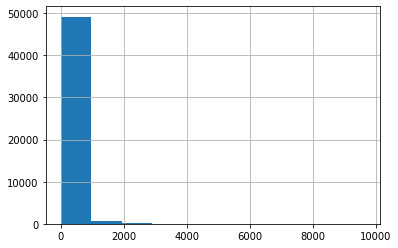

In [36]:
df['Number of Reviews'].hist()
df['Number of Reviews'].describe()

In [37]:
df.loc[df['Number of Reviews'] == df['Number of Reviews'].max()]

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine
29251,id_375,London,376.0,4.0,9660.0,"[['Lovely setting and decent food', 'A Christm...",/Restaurant_Review-g186338-d1421189-Reviews-Lo...,d1421189,1,4.0,3


In [38]:
df.iloc[29251]['URL_TA']

'/Restaurant_Review-g186338-d1421189-Reviews-London_Steakhouse_Co-London_England.html'

По ссылке выше у ресторана на данный момент 14830 отзывов, значит всё в порядке.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
Cuisine              50000 non-null int64
dtypes: float64(4), int64(2), object(5)
memory usage: 4.6+ MB


В датафрейме осталось 5 столбцов типа object, два из которых до освоения парсинга мне не пригодятся. Удалим их.

In [40]:
df.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)

Так как в датафрейме в колонке Ranking представлены места ресторанов среди всех ресторанов города, то необходимо узнать количество ресторанов в каждом городе. Хорошо, что в нашем датафрейме только 31 город.

In [41]:
df['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [42]:
df['City'].nunique()

31

In [43]:
def rest_count(x):
    if x == 'London':
        return 16979
    elif x == 'Paris':
        return 15467
    elif x == 'Madrid':
        return 10112
    elif x == 'Barcelona':
        return 8622
    elif x == 'Berlin':
        return 5784
    elif x == 'Milan':
        return 6668
    elif x == 'Rome':
        return 10177
    elif x == 'Prague':
        return 4631
    elif x == 'Lisbon':
        return 4486
    elif x == 'Vienna':
        return 3738
    elif x == 'Amsterdam':
        return 3649
    elif x == 'Brussels':
        return 2362
    elif x == 'Hamburg':
        return 2885
    elif x == 'Munich':
        return 2848
    elif x == 'Lyon':
        return 2519
    elif x == 'Stockholm':
        return 2729
    elif x == 'Budapest':
        return 2750
    elif x == 'Warsaw':
        return 2739
    elif x == 'Dublin':
        return 2082
    elif x == 'Copenhagen':
        return 1968
    elif x == 'Athens':
        return 2300
    elif x == 'Edinburgh':
        return 1730
    elif x == 'Zurich':
        return 1660
    elif x == 'Oporto':
        return 1829
    elif x == 'Geneva':
        return 1324
    elif x == 'Krakow':
        return 1494
    elif x == 'Oslo':
        return 1165
    elif x == 'Helsinki':
        return 1352
    elif x == 'Bratislava':
        return 1041
    elif x == 'Luxembourg':
        return 659
    elif x == 'Ljubljana':
        return 539

Создадим новую колонку с количеством ресторанов в каждом городе.

In [44]:
df['count_rest'] = df.City.apply(rest_count)

Создадим новую колонку, в которой присвоим каждому ресторану рейтинг среди всех ресторанов. Если ресторан лучший в своем городе, то он получает максимальный балл - 1, если худший, то - 0.

In [45]:
df['city_rest'] = round(1 - (df['Ranking'] / df['count_rest']), 2)

In [46]:
df

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Cuisine,count_rest,city_rest
0,id_0,Paris,12963.0,2.5,4.0,"[[], []]",0,0.0,2,15467,0.16
1,id_1,Helsinki,106.0,2.5,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,5,1352,0.92
2,id_2,Edinburgh,810.0,2.5,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,1,1730,0.53
3,id_3,London,1669.0,4.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,5,16979,0.90
4,id_4,Bratislava,37.0,4.0,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,6,1041,0.96
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,500.0,2.5,79.0,"[['The real Italian experience!', 'Wonderful f...",1,4.5,4,6668,0.93
49996,id_6340,Paris,6341.0,2.5,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",1,3.5,5,15467,0.59
49997,id_1649,Stockholm,1652.0,2.5,4.0,"[['Good by swedish standards', 'A hidden jewel...",1,4.5,2,2729,0.39
49998,id_640,Warsaw,641.0,2.5,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1,4.0,5,2739,0.77


Создадим колонку с плотностью населения каждого города, вручную, конечно.

In [47]:
def people_count(x):
    if x == 'London':
        return 5667
    elif x == 'Paris':
        return 20781
    elif x == 'Madrid':
        return 5380
    elif x == 'Barcelona':
        return 16428
    elif x == 'Berlin':
        return 4088
    elif x == 'Milan':
        return 7589
    elif x == 'Rome':
        return 2234
    elif x == 'Prague':
        return 2506
    elif x == 'Lisbon':
        return 5055
    elif x == 'Vienna':
        return 4503
    elif x == 'Amsterdam':
        return 4768
    elif x == 'Brussels':
        return 5497
    elif x == 'Hamburg':
        return 2389
    elif x == 'Munich':
        return 4713
    elif x == 'Lyon':
        return 10041
    elif x == 'Stockholm':
        return 5140
    elif x == 'Budapest':
        return 3331
    elif x == 'Warsaw':
        return 3449
    elif x == 'Dublin':
        return 3689
    elif x == 'Copenhagen':
        return 6215
    elif x == 'Athens':
        return 7500
    elif x == 'Edinburgh':
        return 4140
    elif x == 'Zurich':
        return 4666
    elif x == 'Oporto':
        return 5703
    elif x == 'Geneva':
        return 12589
    elif x == 'Krakow':
        return 2384
    elif x == 'Oslo':
        return 1483
    elif x == 'Helsinki':
        return 3058
    elif x == 'Bratislava':
        return 1189
    elif x == 'Luxembourg':
        return 234
    elif x == 'Ljubljana':
        return 1736

In [48]:
df['people'] = df.City.apply(people_count)

Стандартизация признака

In [49]:
from sklearn import preprocessing
df['people'] = preprocessing.scale(df['people'])

In [50]:
df['people'] = round(df['people'], 2)

In [51]:
df

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Cuisine,count_rest,city_rest,people
0,id_0,Paris,12963.0,2.5,4.0,"[[], []]",0,0.0,2,15467,0.16,2.20
1,id_1,Helsinki,106.0,2.5,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,5,1352,0.92,-0.77
2,id_2,Edinburgh,810.0,2.5,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,1,1730,0.53,-0.58
3,id_3,London,1669.0,4.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,5,16979,0.90,-0.33
4,id_4,Bratislava,37.0,4.0,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,6,1041,0.96,-1.08
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,500.0,2.5,79.0,"[['The real Italian experience!', 'Wonderful f...",1,4.5,4,6668,0.93,-0.01
49996,id_6340,Paris,6341.0,2.5,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",1,3.5,5,15467,0.59,2.20
49997,id_1649,Stockholm,1652.0,2.5,4.0,"[['Good by swedish standards', 'A hidden jewel...",1,4.5,2,2729,0.39,-0.42
49998,id_640,Warsaw,641.0,2.5,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1,4.0,5,2739,0.77,-0.70


Создадим столбец date_time, выделив из столбца Reviews даты отзывов. 

In [52]:
df['Reviews'].isna().sum()

2

In [53]:
df['Reviews'] = df['Reviews'].fillna('error')

In [55]:
df['Reviews'].isna().sum()

0

In [56]:
pattern = re.compile('\d+\/\d+\/\d+')
df['date_time'] = df['Reviews'].apply(pattern.findall)

Разобъем полученный столбец на 2 столбца, отделив дату первого и последнего отзыва.

In [57]:
df['date_time_1'] = df['date_time'].apply(
    lambda x: x[0] if len(x) >= 1 else None)
df['date_time_2'] = df['date_time'].apply(
    lambda x: x[1] if len(x) == 2 else None)

In [58]:
df = df.drop(['Reviews'], axis=1)

Приведем столбцы в формат datetime, предварительно заполнив пробелы.

In [59]:
df['date_time_1'] = df['date_time_1'].apply(
    lambda x: 0 if x == None else x)
df['date_time_1'] = pd.to_datetime(df['date_time_1'])

In [60]:
df['date_time_2'] = df['date_time_2'].apply(
    lambda x: 0 if x == None else x)
df['date_time_2'] = pd.to_datetime(df['date_time_2'])

In [61]:
df

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine,count_rest,city_rest,people,date_time,date_time_1,date_time_2
0,id_0,Paris,12963.0,2.5,4.0,0,0.0,2,15467,0.16,2.20,[],1970-01-01,1970-01-01
1,id_1,Helsinki,106.0,2.5,97.0,0,0.0,5,1352,0.92,-0.77,"[12/05/2017, 10/29/2017]",2017-12-05,2017-10-29
2,id_2,Edinburgh,810.0,2.5,28.0,0,0.0,1,1730,0.53,-0.58,"[12/28/2017, 12/06/2017]",2017-12-28,2017-12-06
3,id_3,London,1669.0,4.0,202.0,0,0.0,5,16979,0.90,-0.33,"[12/06/2017, 11/22/2017]",2017-12-06,2017-11-22
4,id_4,Bratislava,37.0,4.0,162.0,0,0.0,6,1041,0.96,-1.08,"[02/08/2018, 01/24/2018]",2018-02-08,2018-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,500.0,2.5,79.0,1,4.5,4,6668,0.93,-0.01,"[12/16/2017, 11/12/2017]",2017-12-16,2017-11-12
49996,id_6340,Paris,6341.0,2.5,542.0,1,3.5,5,15467,0.59,2.20,"[12/21/2017, 12/12/2017]",2017-12-21,2017-12-12
49997,id_1649,Stockholm,1652.0,2.5,4.0,1,4.5,2,2729,0.39,-0.42,"[11/03/2016, 04/12/2008]",2016-11-03,2008-04-12
49998,id_640,Warsaw,641.0,2.5,70.0,1,4.0,5,2739,0.77,-0.70,"[07/11/2017, 06/18/2017]",2017-07-11,2017-06-18


Создадим столбец date_days с разницей в днях между первым и последним отзывом.

In [62]:
df['date_days'] = (abs(df['date_time_2'] - df['date_time_1']))

In [63]:
df['date_days'] = df['date_days'].astype(str)

In [64]:
pattern = re.compile('\d*')

In [65]:
df['date'] = df['date_days'].apply(pattern.findall)

In [66]:
df['date'] = df['date'].apply(lambda x: x[0])

In [67]:
df

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine,count_rest,city_rest,people,date_time,date_time_1,date_time_2,date_days,date
0,id_0,Paris,12963.0,2.5,4.0,0,0.0,2,15467,0.16,2.20,[],1970-01-01,1970-01-01,0 days 00:00:00.000000000,0
1,id_1,Helsinki,106.0,2.5,97.0,0,0.0,5,1352,0.92,-0.77,"[12/05/2017, 10/29/2017]",2017-12-05,2017-10-29,37 days 00:00:00.000000000,37
2,id_2,Edinburgh,810.0,2.5,28.0,0,0.0,1,1730,0.53,-0.58,"[12/28/2017, 12/06/2017]",2017-12-28,2017-12-06,22 days 00:00:00.000000000,22
3,id_3,London,1669.0,4.0,202.0,0,0.0,5,16979,0.90,-0.33,"[12/06/2017, 11/22/2017]",2017-12-06,2017-11-22,14 days 00:00:00.000000000,14
4,id_4,Bratislava,37.0,4.0,162.0,0,0.0,6,1041,0.96,-1.08,"[02/08/2018, 01/24/2018]",2018-02-08,2018-01-24,15 days 00:00:00.000000000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,500.0,2.5,79.0,1,4.5,4,6668,0.93,-0.01,"[12/16/2017, 11/12/2017]",2017-12-16,2017-11-12,34 days 00:00:00.000000000,34
49996,id_6340,Paris,6341.0,2.5,542.0,1,3.5,5,15467,0.59,2.20,"[12/21/2017, 12/12/2017]",2017-12-21,2017-12-12,9 days 00:00:00.000000000,9
49997,id_1649,Stockholm,1652.0,2.5,4.0,1,4.5,2,2729,0.39,-0.42,"[11/03/2016, 04/12/2008]",2016-11-03,2008-04-12,3127 days 00:00:00.000000000,3127
49998,id_640,Warsaw,641.0,2.5,70.0,1,4.0,5,2739,0.77,-0.70,"[07/11/2017, 06/18/2017]",2017-07-11,2017-06-18,23 days 00:00:00.000000000,23


Переведем столбец date в числовой формат.

In [68]:
df['date'] = df['date'].astype(int)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
sample               50000 non-null int64
Rating               50000 non-null float64
Cuisine              50000 non-null int64
count_rest           50000 non-null int64
city_rest            50000 non-null float64
people               50000 non-null float64
date_time            50000 non-null object
date_time_1          50000 non-null datetime64[ns]
date_time_2          50000 non-null datetime64[ns]
date_days            50000 non-null object
date                 50000 non-null int32
dtypes: datetime64[ns](2), float64(6), int32(1), int64(3), object(4)
memory usage: 6.3+ MB


Стандартизируем признак.

In [70]:
from sklearn import preprocessing
df['date'] = preprocessing.scale(df['date'])

In [71]:
df['date'] = round(df['date'], 2)

In [72]:
df

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine,count_rest,city_rest,people,date_time,date_time_1,date_time_2,date_days,date
0,id_0,Paris,12963.0,2.5,4.0,0,0.0,2,15467,0.16,2.20,[],1970-01-01,1970-01-01,0 days 00:00:00.000000000,-0.38
1,id_1,Helsinki,106.0,2.5,97.0,0,0.0,5,1352,0.92,-0.77,"[12/05/2017, 10/29/2017]",2017-12-05,2017-10-29,37 days 00:00:00.000000000,-0.37
2,id_2,Edinburgh,810.0,2.5,28.0,0,0.0,1,1730,0.53,-0.58,"[12/28/2017, 12/06/2017]",2017-12-28,2017-12-06,22 days 00:00:00.000000000,-0.38
3,id_3,London,1669.0,4.0,202.0,0,0.0,5,16979,0.90,-0.33,"[12/06/2017, 11/22/2017]",2017-12-06,2017-11-22,14 days 00:00:00.000000000,-0.38
4,id_4,Bratislava,37.0,4.0,162.0,0,0.0,6,1041,0.96,-1.08,"[02/08/2018, 01/24/2018]",2018-02-08,2018-01-24,15 days 00:00:00.000000000,-0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,500.0,2.5,79.0,1,4.5,4,6668,0.93,-0.01,"[12/16/2017, 11/12/2017]",2017-12-16,2017-11-12,34 days 00:00:00.000000000,-0.37
49996,id_6340,Paris,6341.0,2.5,542.0,1,3.5,5,15467,0.59,2.20,"[12/21/2017, 12/12/2017]",2017-12-21,2017-12-12,9 days 00:00:00.000000000,-0.38
49997,id_1649,Stockholm,1652.0,2.5,4.0,1,4.5,2,2729,0.39,-0.42,"[11/03/2016, 04/12/2008]",2016-11-03,2008-04-12,3127 days 00:00:00.000000000,0.21
49998,id_640,Warsaw,641.0,2.5,70.0,1,4.0,5,2739,0.77,-0.70,"[07/11/2017, 06/18/2017]",2017-07-11,2017-06-18,23 days 00:00:00.000000000,-0.38


### Анализ целевой переменной

In [73]:
score_mean = round(df['Rating'].mean(), 2)
score_median = df['Rating'].median()
score_mode = df['Rating'].mode()[0]

print('Среднее:', score_mean)
print('Медиана:', score_median)
print('Мода:', score_mode)

Среднее: 3.19
Медиана: 4.0
Мода: 4.0


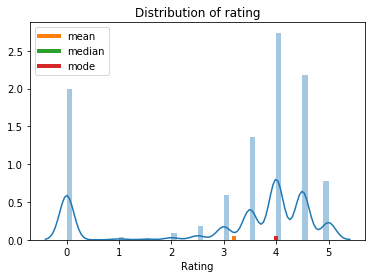

In [74]:
sns.distplot(df['Rating'])

y = np.linspace(0, 0.02, 100)
plt.plot([score_mean]*100, y, label='mean', linestyle='-', linewidth=4)
plt.plot([score_median]*100, y, label='median', linestyle='-', linewidth=4)
plt.plot([score_mode]*100, y, label='mode', linestyle='-', linewidth=4)
plt.title('Distribution of rating')
plt.legend(loc='upper left')
plt.show()

In [75]:
df

,Restaurant_id,City,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine,count_rest,city_rest,people,date_time,date_time_1,date_time_2,date_days,date
0,id_0,Paris,12963.0,2.5,4.0,0,0.0,2,15467,0.16,2.20,[],1970-01-01,1970-01-01,0 days 00:00:00.000000000,-0.38
1,id_1,Helsinki,106.0,2.5,97.0,0,0.0,5,1352,0.92,-0.77,"[12/05/2017, 10/29/2017]",2017-12-05,2017-10-29,37 days 00:00:00.000000000,-0.37
2,id_2,Edinburgh,810.0,2.5,28.0,0,0.0,1,1730,0.53,-0.58,"[12/28/2017, 12/06/2017]",2017-12-28,2017-12-06,22 days 00:00:00.000000000,-0.38
3,id_3,London,1669.0,4.0,202.0,0,0.0,5,16979,0.90,-0.33,"[12/06/2017, 11/22/2017]",2017-12-06,2017-11-22,14 days 00:00:00.000000000,-0.38
4,id_4,Bratislava,37.0,4.0,162.0,0,0.0,6,1041,0.96,-1.08,"[02/08/2018, 01/24/2018]",2018-02-08,2018-01-24,15 days 00:00:00.000000000,-0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,500.0,2.5,79.0,1,4.5,4,6668,0.93,-0.01,"[12/16/2017, 11/12/2017]",2017-12-16,2017-11-12,34 days 00:00:00.000000000,-0.37
49996,id_6340,Paris,6341.0,2.5,542.0,1,3.5,5,15467,0.59,2.20,"[12/21/2017, 12/12/2017]",2017-12-21,2017-12-12,9 days 00:00:00.000000000,-0.38
49997,id_1649,Stockholm,1652.0,2.5,4.0,1,4.5,2,2729,0.39,-0.42,"[11/03/2016, 04/12/2008]",2016-11-03,2008-04-12,3127 days 00:00:00.000000000,0.21
49998,id_640,Warsaw,641.0,2.5,70.0,1,4.0,5,2739,0.77,-0.70,"[07/11/2017, 06/18/2017]",2017-07-11,2017-06-18,23 days 00:00:00.000000000,-0.38


Удалим все вспомогательные колонки и колонки с типом данных object

In [76]:
df = df.drop(['Restaurant_id', 'Ranking', 'City', 'count_rest',
                  'date_time', 'date_time_1', 'date_time_2', 'date_days'], axis=1)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 8 columns):
Price Range          50000 non-null float64
Number of Reviews    50000 non-null float64
sample               50000 non-null int64
Rating               50000 non-null float64
Cuisine              50000 non-null int64
city_rest            50000 non-null float64
people               50000 non-null float64
date                 50000 non-null float64
dtypes: float64(6), int64(2)
memory usage: 3.4 MB


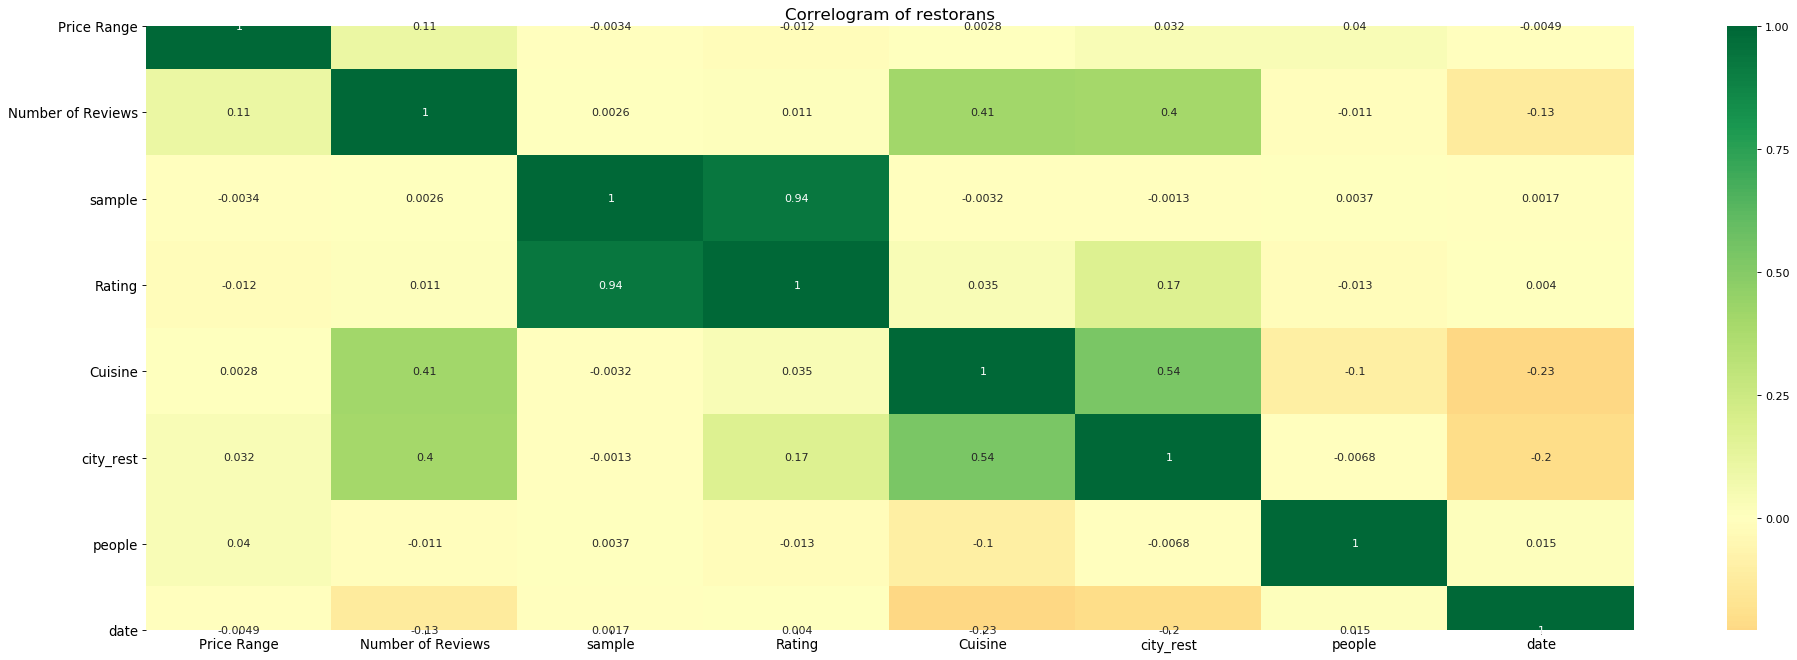

In [80]:
plt.figure(figsize=(30, 10), dpi=80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns,
            yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of restorans', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [81]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
y = train_data.Rating.values            
X = train_data.drop(['Rating'], axis=1)

In [82]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [83]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [84]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 7), (40000, 7), (40000, 6), (30000, 6), (10000, 6))

In [85]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 10000 to 49999
Data columns (total 6 columns):
Price Range          40000 non-null float64
Number of Reviews    40000 non-null float64
Cuisine              40000 non-null int64
city_rest            40000 non-null float64
people               40000 non-null float64
date                 40000 non-null float64
dtypes: float64(5), int64(1)
memory usage: 2.1 MB


In [86]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# инструменты для оценки точности модели
from sklearn import metrics 

In [87]:
# Создаём модель
regr = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [88]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.22583050616328115


Выведем самые важные признаки для модели

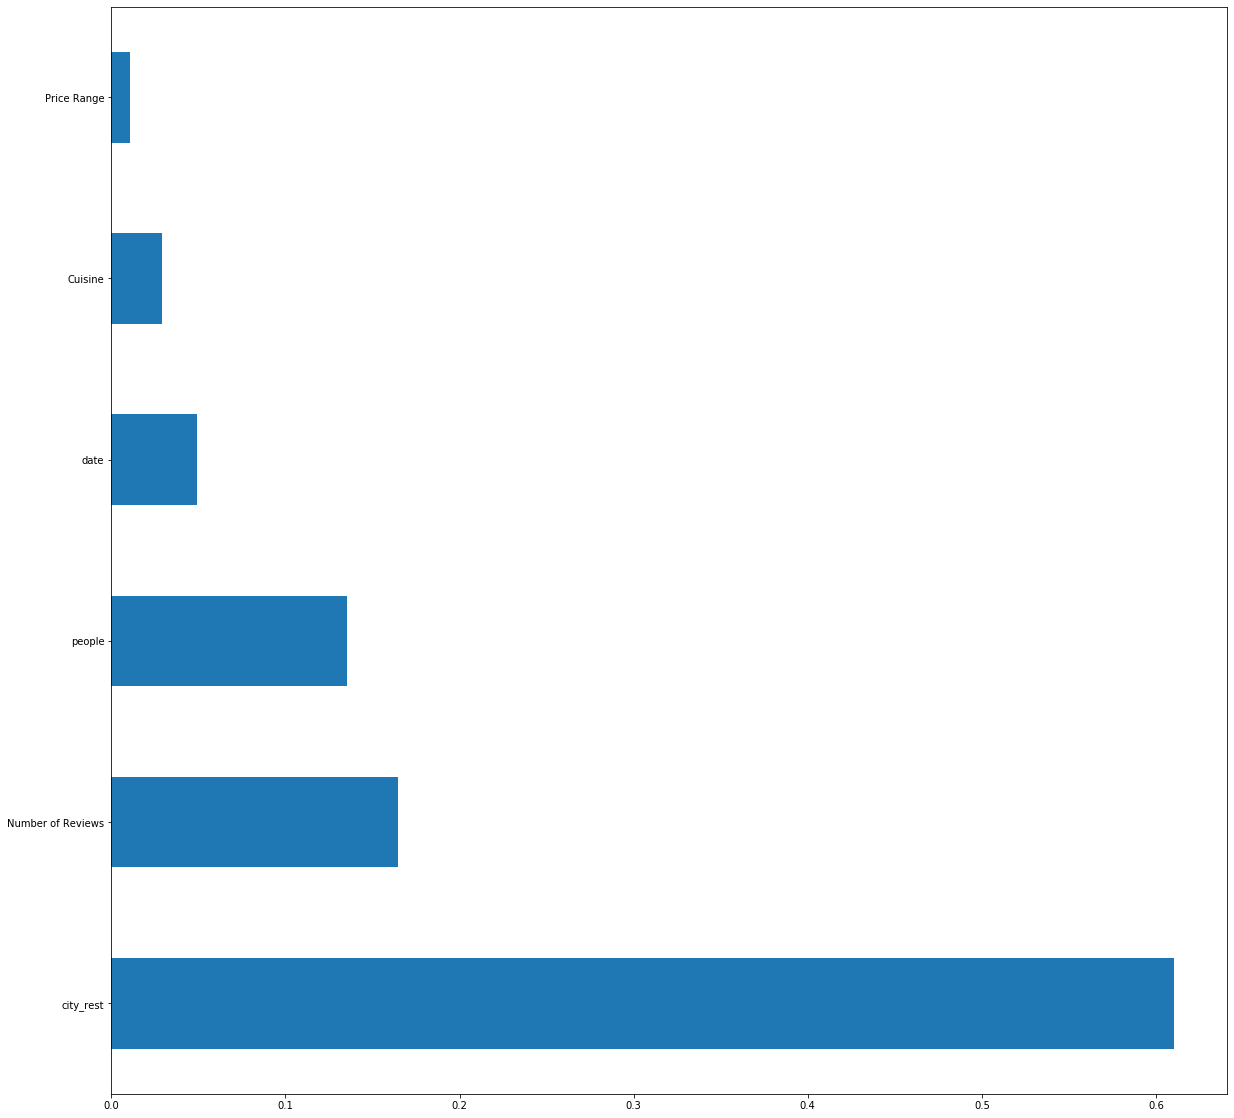

In [89]:
plt.rcParams['figure.figsize'] = (20, 20)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [90]:
test_data.sample(10)

,Price Range,Number of Reviews,Rating,Cuisine,city_rest,people,date
2928,2.5,12.0,0.0,1,0.16,-0.33,-0.36
691,2.5,5.0,0.0,1,0.23,-0.01,-0.38
1631,2.5,11.0,0.0,1,0.19,-0.33,-0.33
613,2.5,19.0,0.0,2,0.28,-0.59,-0.37
3152,2.5,41.0,0.0,4,0.59,-0.01,2.83
1098,2.5,53.0,0.0,3,0.43,-0.70,-0.25
5097,2.5,11.0,0.0,1,0.30,-0.33,-0.26
5830,1.0,8.0,0.0,4,0.34,-0.59,-0.31
726,2.5,108.0,0.0,5,0.73,-0.32,-0.35
1498,2.5,3.0,0.0,1,0.59,-0.86,-0.38


In [91]:
test_data = test_data.drop(['Rating'], axis=1)

In [92]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [93]:
predict_submission

array([3.1347619 , 4.355     , 4.235     , ..., 3.005     , 4.48341667,
       4.42      ])

Создадим файл с предсказаниями.

In [94]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.134762
1,id_1,4.355000
2,id_2,4.235000
3,id_3,4.185000
4,id_4,4.545000
5,id_5,4.470000
6,id_6,1.715000
7,id_7,2.710000
8,id_8,4.485000
9,id_9,4.805000


### Выводы

* Пустые значения в данных были заполнены медианой.
* Выбросы не найдены.
* Сгенерированы новые признаки: количество кухонь в каждом ресторане, признак плотности населения по городам, общий рейтинг ресторанов. 
* Были созданы и опробованы модели с dummy признаками по городам, по кухням (популярным), с признаком 'Restaurant_id' (в датасете много сетевых ресторанов, т.е с одинаковыми значениями этого признака). Самый лучший результат MAE получился в представленной модели.